The code below connects (or mounts) Google Drive to Google Colab documents. This is done for simplicity. To do that, you just need:

1) Press the Run button

2) Log in to google account

3) Allow google the extensions it asks for.

P.S.Further down in the code where actual pre-processing starts ( for example, with stemming and lemmatization) you will simply need to update input_path and output_path variables for the code to automatically make the required pre-processed data set. Please scroll down, you will see the comments near these variables which state what should be updated.

In [1]:
from google.colab import drive
drive.mount('/content/drive') #Just press the Run button here and look in 'Files' on the left

Mounted at /content/drive


In [2]:
import os
import tarfile
file_path ="/content/drive/MyDrive/ML Project/Report folder/*USE ME* 20news-bydate.tar.gz" # Update with the correct file path in google drive

# Extract the tar.gz file
with tarfile.open(file_path, "r:gz") as tar:
    tar.extractall("extracted_dataset")  # Extract into a new folder

Data analysis: We need to see with what type of documents we are working with for example, if it is an e-mail style document or something else.

We can use probability to estimate what is the chance that most or all documents we are working with are e-mail type , see the report for explanations.

This will be a proof for our pre-processing technique of removing e-mail attributes ( like "From" or "Sender") therefore leading to a reasonable usage of these techniques. If we just assume with no proofs that all docs are e-mails it will be a very crude assumption.

In [ ]:
#The code here: Randomly pick text documents from each category and calculate how many of them
#contain the e-mail attributes.
import os
import random

# Path to the main directory containing the category folders
MAIN_DIRECTORY = "/content/extracted_dataset/20news-bydate-train" #20news-bydate-train, need to leave like that or put 20news-bydate-test

# Email attribute keywords
EMAIL_KEYWORDS = ["Subject:", "From:", "To:", "Date:", "Message-ID:", "Cc:", "Bcc:", "Reply-To:"]

# Counters
num_emails = 0
num_other = 0
other_files_list = []

# Function to check if a file has email attributes
def is_email(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
            for line in lines[:20]:  # Check only the first 20 lines to improve performance
                if any(keyword in line for keyword in EMAIL_KEYWORDS):
                    return True
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
    return False

# Process each category folder
for category in os.listdir(MAIN_DIRECTORY):
    category_path = os.path.join(MAIN_DIRECTORY, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        text_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

       # print(f"Category '{category}' contains {len(text_files)} files.")  # Debugging info

        #if len(text_files) < 158:
          #  print(f"Warning: Category '{category}' has less than 158 files, using all available.")

        # Randomly select 10 files (or all if fewer)
        selected_files = random.sample(text_files, min(158, len(text_files)))

        for file_name in selected_files:
            file_path = os.path.join(category_path, file_name)

            if is_email(file_path):
                num_emails += 1
            else:
                num_other += 1
                other_files_list.append((file_name, category))

# Print results
print(f"Number of e-mails: {num_emails}")
print(f"Other: {num_other}")
print("List of non-email files:")
for file_info in other_files_list:
    print(f"File: {file_info[0]}, Category: {file_info[1]}")

Number of e-mails: 3160
Other: 0
List of non-email files:


The result above shows that out of the randomly picked files, 100% of them are e-mails. Please, see the report for further explanations

The code below is searching for empty files within each topic and identifies it inside the list. It is important to know since this may affect our box-plot analysis and definitely affects the model training.

In [ ]:
import os

# Path to the main directory containing the category folders
MAIN_DIRECTORY = "/content/extracted_dataset/20news-bydate-train"

# Dictionary to store empty files by category
empty_files_by_category = {}

# Process each category folder
for category in os.listdir(MAIN_DIRECTORY):
    category_path = os.path.join(MAIN_DIRECTORY, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        text_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

        #print(f"Category '{category}' contains {len(text_files)} files.")  # Debugging info

        # Initialize list for this category
        empty_files_by_category[category] = []

        for file_name in text_files:
            file_path = os.path.join(category_path, file_name)

            try:
                if os.path.getsize(file_path) == 0:
                    empty_files_by_category[category].append(file_name)
            except Exception as e:
                print(f"Error checking file {file_path}: {e}")

# Print results
print("\nEmpty files by category:")
for category, empty_files in empty_files_by_category.items():
    print(f"{category}: {empty_files}")



Empty files by category:
comp.os.ms-windows.misc: []
sci.electronics: []
comp.sys.ibm.pc.hardware: []
rec.motorcycles: []
talk.politics.misc: []
sci.crypt: []
misc.forsale: []
sci.med: []
rec.sport.hockey: []
rec.autos: []
soc.religion.christian: []
alt.atheism: []
comp.graphics: []
talk.politics.mideast: []
comp.windows.x: []
comp.sys.mac.hardware: []
talk.religion.misc: []
talk.politics.guns: []
sci.space: []
rec.sport.baseball: []


This was also done with train data set. There are no empty files in any of these topics ( either train or test set).

The code below analyses if there are e-mails which are non - English (i.e. either a different language from English or 'spam'). It is important because pre-processing techniques like stemming and lemmatization may not be the best for non-English e-mails however it is important to see the performance later

P.S. 'spam' in this case is not a separate classification, its noise which may affect classification

In [ ]:
!pip install langdetect

import os
from langdetect import detect

# Path to the main directory containing the category folders
MAIN_DIRECTORY = "/content/extracted_dataset/20news-bydate-train"

# Dictionary to store non-English filenames by category
non_english_by_category = {}

# Process each category folder
for category in os.listdir(MAIN_DIRECTORY):
    category_path = os.path.join(MAIN_DIRECTORY, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        text_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]

        non_english_files = []  # List to store non-English filenames

        for file_name in text_files:
            file_path = os.path.join(category_path, file_name)

            try:
                with open(file_path, 'r', errors='ignore') as file:
                    content = file.read().strip()
                    if content:
                        lang = detect(content)
                        if lang != 'en':
                            non_english_files.append(file_name)
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

        # Store results in the desired format
        if non_english_files:
            non_english_by_category[category] = ["Yes"] + non_english_files
        else:
            non_english_by_category[category] = ["No"]

# Print results
print("\nNon-English document presence by category:")
for category, result in non_english_by_category.items():
    print(f"{category}: {result}")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=457609196aa032bfa8176d2351dd4bbfa743ba750e84b8bf91453a8a82e4e40e
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect

Non-English document presence by category:
comp.os.ms-windows.misc: ['Yes', '9979', '9985', '9984', '9987', '9983', '9978', '9988', '9990', '9980', '9982', '9544', '9986', '9981']
sci.electronics: ['Yes', '52751']
comp.sys.ibm.pc.hardware: ['No']
rec.motorcycles: ['No']
talk.politics.misc: ['No']
sci.crypt: ['No']
misc.forsale: ['Yes', '74798']
sci.med: ['No']
rec.sport.hockey: ['No']
rec.autos: ['No']
soc.religion.christian: ['No']
alt.atheism: ['No']
comp.graphics: ['No']
talk.politics.mideast: ['Yes', '76262', '75381']
comp.windows.x: ['No']
comp.sys.mac.hardware: ['Yes

It was done for train data first and the code above shows that there is an e-mail fully in (German?) in rec.sport.hockey. It highlights it as a noisy minority making it ambiguous , therefore it should be dealt with.
The test data has a lot of redundant e-mails , which dont help the classification. This will be dealt with below.

In [ ]:
updated_dataset="/content/extracted_dataset/20news-bydate-test"
categories=sorted(os.listdir("/content/extracted_dataset/20news-bydate-test"))
print(categories)
#Code for data categories exploration
#In both variables above, just replace with the link to
# your folder. The links must be the same.

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


The code below calculates the amount of documents per category and also if you wish, prints out the text documents that are stored in the path.

In [ ]:
import os

# Step 1: Prompt for dataset path
save_path = input("Enter the dataset path: ").strip() #It will be required to enter the path of the data set here

# Step 2: Validate path
if not os.path.exists(save_path):
    raise FileNotFoundError(f"Error: The specified path '{save_path}' does not exist.")

# Step 3: Dictionary to store counts
category_counts = {}

# Step 4: Process each category folder
for category in os.listdir(save_path):
    category_path = os.path.join(save_path, category)

    if os.path.isdir(category_path):
        # Count number of documents in this category
        doc_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
        category_counts[category] = len(doc_files)

        print(f"\n### Category: {category} | {len(doc_files)} documents ###\n")

        # Step 5: Read and preview each document
        for filename in doc_files:
            file_path = os.path.join(category_path, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    text = file.read()

            print(f"Document: {filename}")
            print("-" * 50)
            print(text[:1000])  # Show only the first 1000 characters
            print("\n" + "=" * 50 + "\n")

# Step 6: Final summary of document counts
print("\n Category-wise document count:")
for category, count in category_counts.items():
    print(f"- {category}: {count} documents")



Streaming output truncated to the last 5000 lines.
	                   (including yesterday's games)

NATIONAL WEST	      Won  Lost   Pct.    GB   Last 10  Streak    Home   Road
San Francisco Giants   09   05    .643    --     8-2     Won 2   05-02  04-03
Houston Astros         07   06    .538   1.5     7-3    Lost 1   02-04  05-02
Atlanta Braves         08   07    .533   1.5     4-6     Won 1   04-03  04-04
Los Angeles Dodgers    06   08    .429   3.0     4-6    Lost 1   03-03  03-05
San Diego Padres       05   08    .385   3.5     4-6    Lost 1   03-04  02-04
Colorado Rockies       04   08    .333   4.0     4-6    Lost 2   03-03  01-05
Cincinnati Reds        04   09    .308   4.5     3-7     


Document: 104829
--------------------------------------------------
From: franjion@spot.Colorado.EDU (John Franjione)
Subject: Re: Why is Barry Bonds not batting 4th?
Nntp-Posting-Host: spot.colorado.edu
Organization: University of Colorado, Boulder
Lines: 29

st1ge@Elroy.UH.EDU (Edward Hui) w

<ipython-input-10-9e3ba8e19ccd>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(categories), y=list(counts), palette="coolwarm")


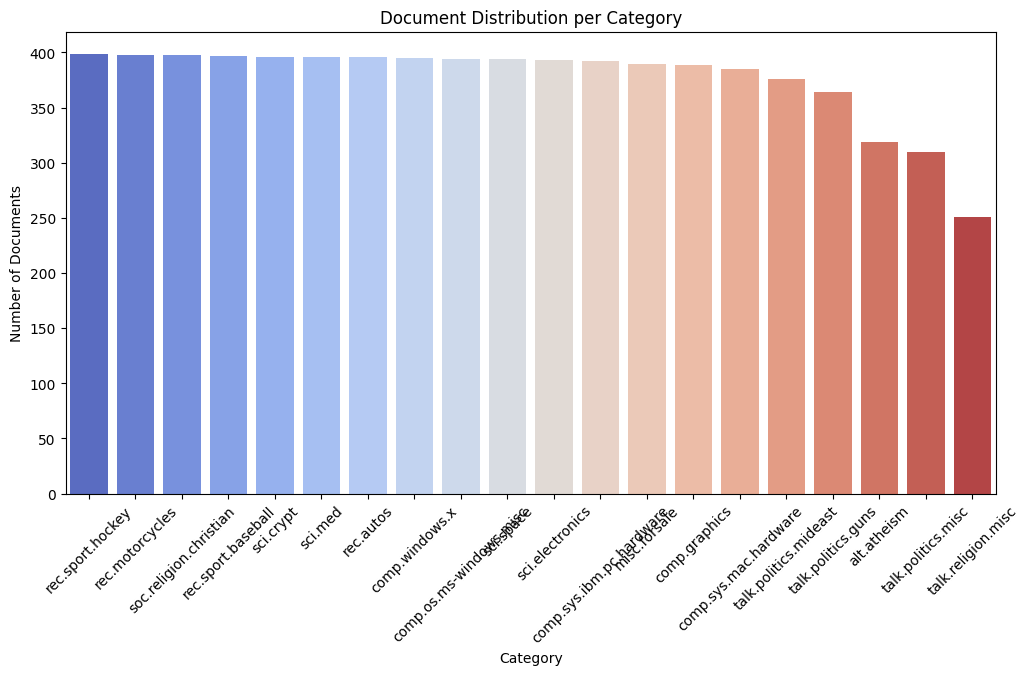

Category with most documents: rec.sport.hockey (399 documents)
Category with least documents: talk.religion.misc (251 documents)
Imbalance Ratio (max/min): 1.5896414342629481


In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = "/content/extracted_dataset/20news-bydate-train"

category_counts = {}

# Count documents per category
for category in os.listdir(save_path):
    category_path = os.path.join(save_path, category)
    if os.path.isdir(category_path):
        num_docs = len([f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))])
        category_counts[category] = num_docs

# Sort categories
sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
categories, counts = zip(*sorted_categories)

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(categories), y=list(counts), palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Number of Documents")
plt.title("Document Distribution per Category")
plt.show()

# Check for imbalance
max_count = max(counts)
min_count = min(counts)
imbalance_ratio = max_count / min_count if min_count > 0 else "Undefined"

print(f"Category with most documents: {categories[0]} ({max_count} documents)")
print(f"Category with least documents: {categories[-1]} ({min_count} documents)")
print(f"Imbalance Ratio (max/min): {imbalance_ratio}")

The code below shows the average length of documents per category

<ipython-input-11-0a63840ab43c>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(categories), y=list(avg_lengths), palette="viridis")


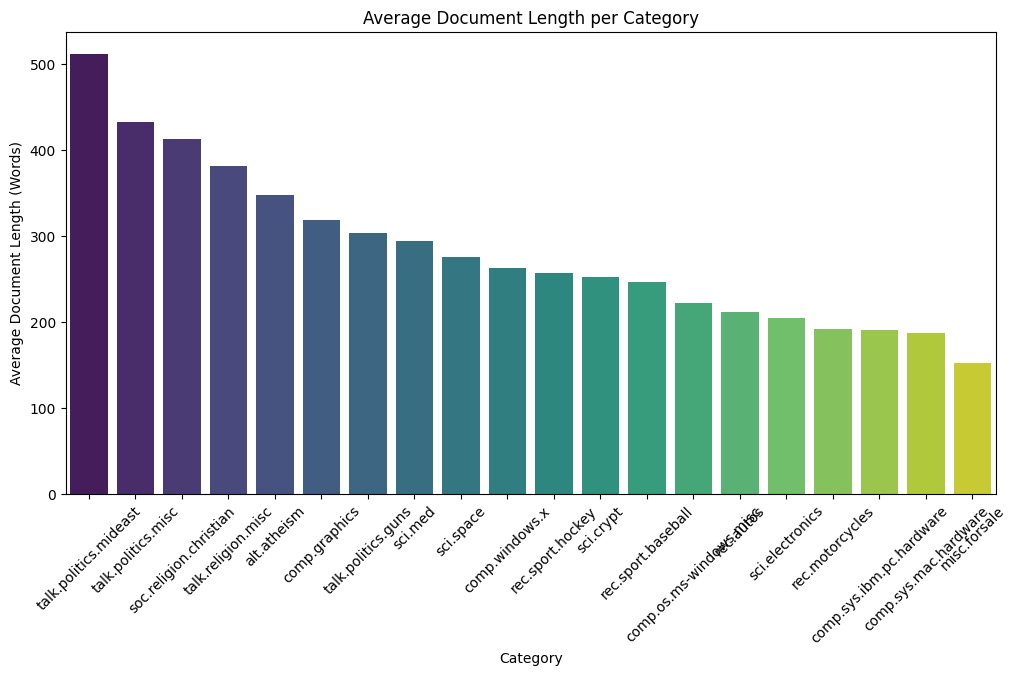

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = "/content/extracted_dataset/20news-bydate-test"  # Change to your dataset path from google disk.
category_lengths = {}

# Loop through each category folder
for category in os.listdir(save_path):
    category_path = os.path.join(save_path, category)

    if os.path.isdir(category_path):  # Ensure it's a folder
        doc_lengths = []

        for file in os.listdir(category_path):
            file_path = os.path.join(category_path, file)

            try:
                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read()
                    doc_lengths.append(len(text.split()))  # Count words in document
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

        if doc_lengths:
            category_lengths[category] = sum(doc_lengths) / len(doc_lengths)  # Average length

# Sort categories by average length
sorted_categories = sorted(category_lengths.items(), key=lambda x: x[1], reverse=True)
categories, avg_lengths = zip(*sorted_categories)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(categories), y=list(avg_lengths), palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Category")
plt.ylabel("Average Document Length (Words)")
plt.title("Average Document Length per Category")
plt.show()
#for category, word_counts in category_word_counts.items():
   # df = pd.DataFrame(word_counts, columns=[f'Word Count in {category}'])
   # print(f"\nCategory: {category} - Word Counts")
   # print(df.describe())  # Get basic stats (mean, std, min, max, etc.)


This code analyses the documents and plots a box plot

Your file path: /content/extracted_dataset/20news-bydate-test


<ipython-input-13-b0f9e9c5a79b>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Category", y="Document_Length", data=df, palette="Set2")


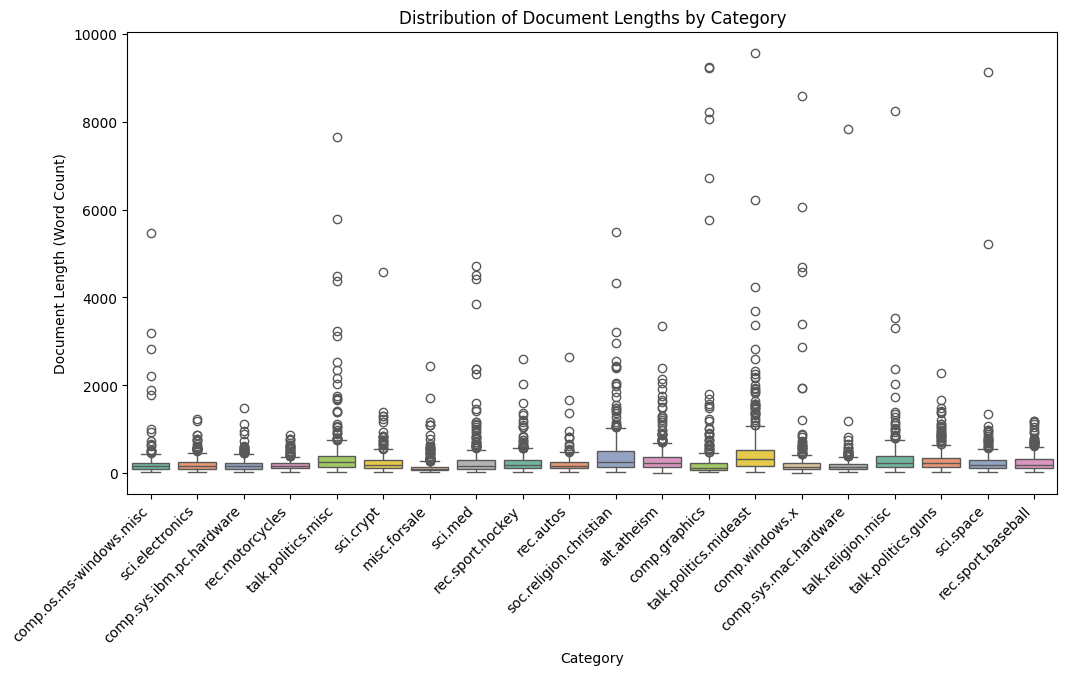


Number of Outliers in Each Category:
comp.os.ms-windows.misc: 18 outliers
sci.electronics: 24 outliers
comp.sys.ibm.pc.hardware: 22 outliers
rec.motorcycles: 27 outliers
talk.politics.misc: 32 outliers
sci.crypt: 23 outliers
misc.forsale: 47 outliers
sci.med: 37 outliers
rec.sport.hockey: 28 outliers
rec.autos: 14 outliers
soc.religion.christian: 27 outliers
alt.atheism: 34 outliers
comp.graphics: 34 outliers
talk.politics.mideast: 38 outliers
comp.windows.x: 30 outliers
comp.sys.mac.hardware: 24 outliers
talk.religion.misc: 22 outliers
talk.politics.guns: 30 outliers
sci.space: 24 outliers
rec.sport.baseball: 25 outliers


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

# Prompt the user to specify the dataset path
save_path = input("Your file path: ").strip()

# Ensure the path exists
if not os.path.exists(save_path):
    raise FileNotFoundError(f"Error: The specified path '{save_path}' does not exist.")

# Dictionary to store document lengths for each category
category_doc_lengths = {}
outlier_counts = {}

# Process each category to compute document lengths
for category in os.listdir(save_path):
    category_path = os.path.join(save_path, category)

    if os.path.isdir(category_path):
        doc_lengths = []

        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    text = file.read()

            # Since preprocessed text is stored directly, split it to count words
            words = text.split()  # Corrected this line
            doc_lengths.append(len(words))  # Store document length

        category_doc_lengths[category] = doc_lengths

        # Compute IQR for outlier detection
        Q1 = np.percentile(doc_lengths, 25)
        Q3 = np.percentile(doc_lengths, 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = [length for length in doc_lengths if length < lower_bound or length > upper_bound]
        outlier_counts[category] = len(outliers)

# Convert dictionary to a format suitable for plotting
data = []
categories = []

for category, lengths in category_doc_lengths.items():
    data.extend(lengths)
    categories.extend([category] * len(lengths))

# Create DataFrame
df = pd.DataFrame({"Category": categories, "Document_Length": data})

# Create box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Category", y="Document_Length", data=df, palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Category")
plt.ylabel("Document Length (Word Count)")
plt.title("Distribution of Document Lengths by Category")
plt.show()

# Print outlier counts
print("\nNumber of Outliers in Each Category:")
for category, count in outlier_counts.items():
    print(f"{category}: {count} outliers")



The code below is responsible for pre-processing with stemming and lemmatization.


In [ ]:
import re
import os
import collections
import unicodedata
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
import nltk

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt_tab")
nltk.download('averaged_perceptron_tagger_eng')

# Initialize tools
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Map POS tag to WordNet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Normalize special characters (é → e, ü → u)
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove emails
    text = re.sub(r"\S+@\S+", "", text)

    # Remove punctuation and special characters but keep numbers temporarily
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove all standalone numbers (any sequence of digits not part of a word)
    text = re.sub(r'\b\d+\b', ' ', text)

    # Tokenize words
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # POS tagging for lemmatization
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize then stem
    tokens = [stemmer.stem(lemmatizer.lemmatize(word, get_wordnet_pos(pos))) for word, pos in pos_tags]

    return tokens

# Paths for input and output
input_path = "/content/extracted_dataset/20news-bydate-test" #Just rename 20news-bydate-test to 20news-bydate-train when you will need to create a pre-processed train set
output_path = "/content/drive/MyDrive/ML Project/Test folder"# just copy a path (right click in the file you want to store the data in) and insert it here for the folder in google disk.

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Dictionary to store word counts for each category
category_word_counts = {}

# Process each category
for category in os.listdir(input_path):
    category_path = os.path.join(input_path, category)

    if os.path.isdir(category_path):  # Ensure it's a folder
        word_counter = collections.Counter()

        # Create category folder in the output directory
        output_category_path = os.path.join(output_path, category)
        os.makedirs(output_category_path, exist_ok=True)

        # Process each document
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            output_file_path = os.path.join(output_category_path, filename)

            # Try opening with 'utf-8', fallback to 'latin-1'
            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    text = file.read()

            # Preprocess the document
            tokens = clean_and_tokenize(text)

            # Save each token in a new line
            with open(output_file_path, "w", encoding="utf-8") as output_file:
                output_file.write("\n".join(tokens))

            # Update word frequency counter
            word_counter.update(tokens)

        # Store most common words
        category_word_counts[category] = word_counter.most_common(10)

# Print most common words per category
for category, common_words in category_word_counts.items():
    print(f"\nCategory: {category}")
    print("Most common words:", common_words)

print("\n Preprocessing complete! Cleaned files are saved in:", output_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!



Category: comp.os.ms-windows.misc
Most common words: [('window', 900), ('_', 525), ('file', 482), ('use', 466), ('line', 451), ('subject', 423), ('do', 406), ('organ', 401), ('c', 383), ('write', 352)]

Category: sci.electronics
Most common words: [('line', 485), ('use', 432), ('subject', 419), ('organ', 391), ('would', 332), ('write', 331), ('one', 303), ('articl', 257), ('univers', 229), ('copi', 220)]

Category: comp.sys.ibm.pc.hardware
Most common words: [('line', 470), ('drive', 416), ('subject', 412), ('organ', 384), ('use', 340), ('card', 283), ('scsi', 268), ('get', 268), ('post', 251), ('write', 227)]

Category: rec.motorcycles
Most common words: [('write', 446), ('line', 440), ('subject', 410), ('organ', 398), ('bike', 378), ('get', 342), ('articl', 322), ('post', 294), ('like', 255), ('dod', 252)]

Category: talk.politics.misc
Most common words: [('peopl', 517), ('would', 496), ('write', 443), ('say', 439), ('go', 406), ('think', 406), ('articl', 376), ('q', 368), ('one', 3

The code below is responsible for further pre-processing and also without stemming and lemmatization

In [4]:
import re
import os
import collections
import unicodedata
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK data
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("punkt_tab")
# Stopwords list
stop_words = set(stopwords.words("english"))

# Function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Normalize special characters (é → e, ü → u)
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # Remove emails
    text = re.sub(r"\S+@\S+", "", text)

    # Remove punctuation, numbers, and special characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize words
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Remove rare words
    word_freq = collections.Counter(tokens)
    tokens = [word for word in tokens if word_freq[word] > 1]


    return tokens  # Return tokens as a list

# Paths for input and output
input_path = "/content/extracted_dataset/20news-bydate-train"
output_path = "/content/drive/MyDrive/ML Project/Test the run/Test 1"

#Note: The pathways for the above directories can be changed either for testing or training set.
# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Dictionary to store word counts for each category
category_word_counts = {}

# Process each category
for category in os.listdir(input_path):
    category_path = os.path.join(input_path, category)

    if os.path.isdir(category_path):  # Ensure it's a folder
        word_counter = collections.Counter()

        # Create category folder in the output directory
        output_category_path = os.path.join(output_path, category)
        os.makedirs(output_category_path, exist_ok=True)

        # Process each document
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            output_file_path = os.path.join(output_category_path, filename)  # Path to save preprocessed file

            # Try opening with 'utf-8', fallback to 'latin-1'
            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    text = file.read()

            # Preprocess the document
            tokens = clean_and_tokenize(text)

            # Save each token in a new line
            with open(output_file_path, "w", encoding="utf-8") as output_file:
                output_file.write("\n".join(tokens))

            # Update word frequency counter
            word_counter.update(tokens)

        # Store most common words
        category_word_counts[category] = word_counter.most_common(10)  # Get top 10 words

# Print most common words per category
for category, common_words in category_word_counts.items():
    print(f"\nCategory: {category}")
    print("Most common words:", common_words)

print("\nPreprocessing complete! Cleaned files are saved in:", output_path)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Category: comp.sys.ibm.pc.hardware
Most common words: [('scsi', 679), ('drive', 628), ('ide', 315), ('card', 301), ('controller', 264), ('drives', 247), ('disk', 244), ('one', 241), ('bus', 226), ('system', 212)]

Category: rec.autos
Most common words: [('car', 709), ('cars', 284), ('would', 283), ('writes', 275), ('article', 233), ('dont', 213), ('one', 197), ('like', 182), ('get', 178), ('engine', 157)]

Category: talk.politics.mideast
Most common words: [('people', 849), ('israel', 692), ('one', 692), ('turkish', 681), ('armenian', 636), ('armenians', 587), ('would', 580), ('israeli', 568), ('said', 528), ('jews', 504)]

Category: comp.os.ms-windows.misc
Most common words: [('maxaxaxaxaxaxaxaxaxaxaxaxaxaxax', 3311), ('windows', 836), ('file', 288), ('files', 228), ('use', 221), ('dos', 221), ('card', 174), ('driver', 160), ('mouse', 156), ('problem', 151)]

Category: soc.religion.christian
Most common words: [('god', 1100), ('would', 611), ('one', 598), ('jesus', 514), ('people', 4

Here, I am doing another set of pre-processing for complete set. This is the one for SC , outlier recognition.

In [5]:
import re
import os
import collections
import unicodedata
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import nltk

# Download necessary NLTK data
nltk.download("stopwords")
nltk.download("punkt_tab")

# Initialize stop words
stop_words = set(stopwords.words("english"))

# Function to clean and tokenize text into character-level n-grams
def clean_and_char_ngrams(text, n_values=(3, 5)):
    # Keep HTML tags (skip removing them)

    # Normalize special characters (e.g., é -> e, ü -> u)
    text = ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

    # Convert to lowercase
    text = text.lower()

    # Remove non-Latin characters but keep spaces and HTML tags
    text = re.sub(r'[^a-zA-Z<>\s/]', ' ', text)

    # Remove stopwords (word-level filtering before n-grams)
    words = text.split()
    filtered_text = ' '.join([word for word in words if word not in stop_words])

    # Generate character-level n-grams
    ngrams = []
    for n in n_values:
        for i in range(len(filtered_text) - n + 1):
            ngrams.append(filtered_text[i:i + n])

    return ngrams

# Paths for input and output
input_path = "/content/extracted_dataset/20news-bydate-test"
output_path = "/content/drive/MyDrive/ML Project/Test the run"

# Ensure the output directory exists
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Dictionary to store n-gram counts for each category
category_ngram_counts = {}

# Process each category
for category in os.listdir(input_path):
    category_path = os.path.join(input_path, category)

    if os.path.isdir(category_path):
        ngram_counter = collections.Counter()

        # Create category folder in the output directory
        output_category_path = os.path.join(output_path, category)
        os.makedirs(output_category_path, exist_ok=True)

        # Process each document
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)
            output_file_path = os.path.join(output_category_path, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    text = file.read()

            # Preprocess the document and extract n-grams
            ngrams = clean_and_char_ngrams(text)

            # Save each n-gram on a new line
            with open(output_file_path, "w", encoding="utf-8") as output_file:
                output_file.write("\n".join(ngrams))

            # Update n-gram frequency counter
            ngram_counter.update(ngrams)

        # Store most common n-grams
        category_ngram_counts[category] = ngram_counter.most_common(10)

# Print most common n-grams per category
for category, common_ngrams in category_ngram_counts.items():
    print(f"\nCategory: {category}")
    print("Most common n-grams:", common_ngrams)

print("\nPreprocessing complete! Cleaned files are saved in:", output_path)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Category: comp.sys.ibm.pc.hardware
Most common n-grams: [(' co', 2240), ('ing', 1795), ('ng ', 1791), ('er ', 1772), ('es ', 1611), ('on ', 1544), ('ed ', 1474), ('ion', 1426), ('com', 1213), ('tio', 1146)]

Category: rec.autos
Most common n-grams: [('er ', 2245), ('ng ', 2211), ('ing', 2183), ('es ', 2058), (' co', 1978), ('ed ', 1760), ('on ', 1741), ('ion', 1489), (' ca', 1486), (' > ', 1384)]

Category: talk.politics.mideast
Most common n-grams: [('ed ', 6681), ('ing', 4696), ('ng ', 4680), ('ion', 4558), ('es ', 4313), ('on ', 3986), (' co', 3527), ('tio', 3413), (' re', 3220), ('er ', 3096)]

Category: comp.os.ms-windows.misc
Most common n-grams: [('ng ', 2089), ('er ', 2085), (' co', 2055), ('ing', 2006), ('es ', 1977), ('on ', 1807), ('ed ', 1760), ('ion', 1747), (' > ', 1628), (' / ', 1474)]

Category: soc.religion.christian
Most common n-grams: [('ed ', 4126), ('ing', 4021), ('ng ', 3869), ('es ', 3652), ('on ', 3531), ('ion', 3526), (' co', 3228), ('tio', 2841), (' re', 283

The code below saves the file_path for the documents so they can be later removed as according to SC. Important stage, needs to be done.  Note: The file_path to the pre-processed files.

In [6]:
import os

# Initialize lists
documents = []
labels = []
file_paths = []

# Prompt for dataset path
input_path = input("Enter the dataset path: ").strip() #Enter the train dataset path (or test if you are on the stage of cleaning both sets)

# Check if path exists
if not os.path.exists(input_path):
    raise FileNotFoundError(f" Path not found: {input_path}")

# Process each category folder
for category in os.listdir(input_path):
    category_path = os.path.join(input_path, category)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)

            # Read file
            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    text = file.read()
            except UnicodeDecodeError:
                with open(file_path, "r", encoding="latin-1") as file:
                    text = file.read()

            # Preprocess and tokenize
            tokenized_text = clean_and_char_ngrams(text)  # Replace with your function
            document_string = " ".join(tokenized_text)

            # Save metadata
            documents.append(document_string)
            labels.append(category)
            file_paths.append(file_path)

# Print confirmation
print(f"\n Processed {len(documents)} documents.")
print(f" Saved file paths for each document.")
print(" Example file paths:")
for fp in file_paths[:5]:
    print(f"   - {fp}")


Enter the dataset path: /content/drive/MyDrive/ML Project/Test the run/Test 1

 Processed 11314 documents.
 Saved file paths for each document.
 Example file paths:
   - /content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60181
   - /content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60175
   - /content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60366
   - /content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60238
   - /content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60363


The code below performs TF-IDF for further analysis. THE ACTUAL FILES ARE NOT MODIFIED, it is saved in the variable for convenience. TF-IDF is performed ONLY on the variable. The files that you are using here must be the same documents you used in the code just above

In [7]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer

# Paths
input_path = input("Enter the dataset path: ").strip()

documents = []
labels = []
file_paths = []  #  Add this

# Read tokenized files
for category in os.listdir(input_path):
    category_path = os.path.join(input_path, category)

    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            file_path = os.path.join(category_path, filename)

            try:
                with open(file_path, "r", encoding="utf-8") as file:
                    ngram_text = file.read().strip()
                    documents.append(ngram_text)
                    labels.append(category)
                    file_paths.append(file_path)  #  Track path here
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

# TF-IDF on already tokenized n-grams
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=lambda x: x.split(), preprocessor=None, token_pattern=None)
X = vectorizer.fit_transform(documents)

# Outputs
print(f"TF-IDF matrix shape: {X.shape}")
print(f"Number of documents: {len(documents)}")
print(f"Unique labels: {set(labels)}")
print("Example file paths tracked:")
print("\n".join(file_paths[:3]))



Enter the dataset path: /content/drive/MyDrive/ML Project/Test the run/Test 1
TF-IDF matrix shape: (11314, 27452)
Number of documents: 11314
Unique labels: {'rec.sport.hockey', 'talk.politics.misc', 'talk.religion.misc', 'sci.space', 'rec.motorcycles', 'rec.autos', 'comp.os.ms-windows.misc', 'sci.med', 'sci.crypt', 'talk.politics.guns', 'alt.atheism', 'comp.graphics', 'comp.sys.mac.hardware', 'misc.forsale', 'comp.sys.ibm.pc.hardware', 'comp.windows.x', 'sci.electronics', 'soc.religion.christian', 'talk.politics.mideast', 'rec.sport.baseball'}
Example file paths tracked:
/content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60181
/content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60175
/content/drive/MyDrive/ML Project/Test the run/Test 1/comp.sys.ibm.pc.hardware/60366


Below it takes the TF-IDF variable and makes a SC graph. This code you just need to run assuming you did run 2 blocks of code above it

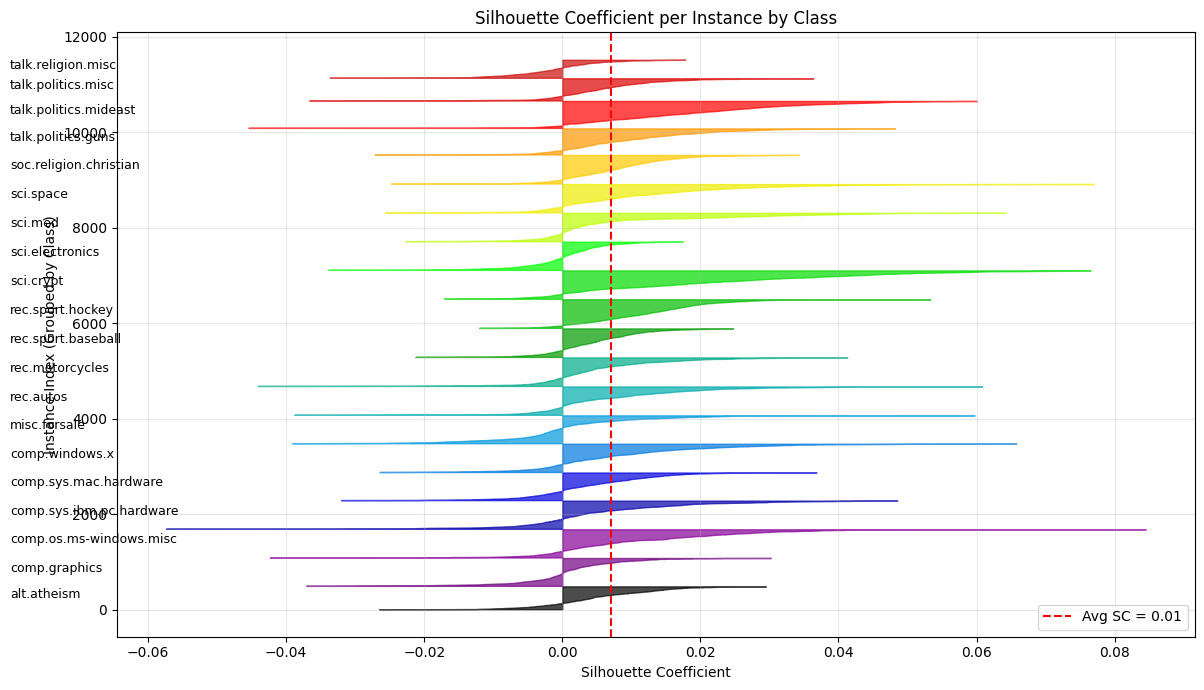

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples
from sklearn.metrics.pairwise import cosine_distances
from sklearn.preprocessing import LabelEncoder

# Assumes you have:
# - X: your TF-IDF feature matrix
# - labels: list of string labels per document

# Step 1: Encode labels as integers
le = LabelEncoder()
label_encoded = le.fit_transform(labels)
class_names = le.classes_
n_clusters = len(class_names)

# Step 2: Compute pairwise cosine distances and silhouette scores
distance_matrix = cosine_distances(X)
silhouette_scores = silhouette_samples(distance_matrix, label_encoded, metric="precomputed")

# Step 3: Initialize plot
y_lower = 10
plt.figure(figsize=(12, 7))

# Step 4: Plot silhouette bands for each class
for i, class_name in enumerate(class_names):
    mask = (label_encoded == i)
    cluster_scores = silhouette_scores[mask]
    cluster_scores.sort()

    size_cluster = len(cluster_scores)
    y_upper = y_lower + size_cluster

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, cluster_scores,
        facecolor=color, edgecolor=color, alpha=0.7
    )

    plt.text(-0.08, y_lower + 0.5 * size_cluster, class_name, fontsize=9)
    y_lower = y_upper + 10

# Step 5: Average SC line
avg_score = np.mean(silhouette_scores)
plt.axvline(x=avg_score, color="red", linestyle="--", label=f"Avg SC = {avg_score:.2f}")

# Final touches
plt.title("Silhouette Coefficient per Instance by Class")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Instance Index (Grouped by Class)")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()





Below is the preparation for removing noisy files (outliers). You just need to run this code

In [ ]:
import numpy as np

# Assumes you already have:
# - silhouette_scores: array of SC values
# - labels: list of original class labels
# - file_paths: full path to each file (in same order as X)
# - X: original TF-IDF matrix

# Step 1: Define the SC range to keep
min_sc = -0.05
max_sc = 0.2

# Step 2: Create list of indices to keep
keep_indices = [
    i for i, sc in enumerate(silhouette_scores)
    if min_sc <= sc <= max_sc
]

# Step 3: Filter data
X_filtered = X[keep_indices]
labels_filtered = [labels[i] for i in keep_indices]
sc_filtered = [silhouette_scores[i] for i in keep_indices]
file_paths_filtered = [file_paths[i] for i in keep_indices]  #  keep these too

# Step 4 (Optional): Gather file paths to delete
delete_indices = [
    i for i, sc in enumerate(silhouette_scores)
    if sc < min_sc or sc > max_sc
]
file_paths_to_delete = [file_paths[i] for i in delete_indices]

# Step 5: Print summary
print(f"\n Kept {len(keep_indices)} of {len(labels)} documents "
      f"({len(keep_indices) / len(labels) * 100:.2f}%)")
print(f" Classes retained: {set(labels_filtered)}")
print(f" Files to delete: {len(file_paths_to_delete)}")




 Kept 6115 of 7532 documents (81.19%)
 Classes retained: {'rec.sport.hockey', 'comp.windows.x', 'talk.politics.guns', 'sci.crypt', 'sci.med', 'alt.atheism', 'rec.autos', 'soc.religion.christian', 'sci.space', 'comp.os.ms-windows.misc', 'talk.politics.mideast', 'rec.sport.baseball', 'comp.graphics', 'comp.sys.mac.hardware', 'comp.sys.ibm.pc.hardware', 'rec.motorcycles', 'sci.electronics', 'talk.politics.misc', 'misc.forsale', 'talk.religion.misc'}
 Files to delete: 1417


Removing the actual documents (below). ATTENTION! this will delete the noisy documents, so press the Run button when you are sure

In [ ]:
import os

# Assumes you already have:
# - file_paths_to_delete: list of full file paths to remove

deleted = 0
failed = []

print("\n Deleting files outside the SC range...")

for path in file_paths_to_delete:
    try:
        os.remove(path)
        deleted += 1
        print(f" Deleted: {path}")
    except Exception as e:
        failed.append((path, str(e)))
        print(f" Failed to delete {path}: {e}")

# Final summary
print(f"\n Successfully deleted {deleted} files.")
if failed:
    print(f" {len(failed)} files failed to delete:")
    for f, err in failed[:5]:  # Show first 5 errors (if any)
        print(f" - {f}: {err}")



 Deleting files outside the SC range...
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10823
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10140
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10943
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10833
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10151
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10935
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10182
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10613
 Deleted: /content/drive/MyDrive/ML Project/Test folder/testing code 2/comp.os.ms-windows.misc/10641
 Deleted: /content/drive/MyDrive/ML Project/Test f